# Kernel Smoothing

In [1]:
import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt

%matplotlib notebook

* In the slides, we saw that in 1-dimension, it can be fairly inuitive to determine where to fit local regression models.

* The same cannot be said for high dimensions.

* Kernel smoothing is class of regression techniques that generalize this idea and are able to achieve flexibility in estimating a regression function $f(X)$ by fitting a different but simple model at each query point $x_0$.

* We do this by only using those obsevations close to the query point $x_0$, in such a way that the resulting estimated function $\hat{f}(X)$ is smooth.

* This is achieved using a weighting function (i.e., a kernel) $k(x_0, x_i)$ which assigns a weight to $x_i$ based on its distance from $x_0$.

* This requires no training at all - all the work gets done at evaluation time.

* In theory the model itself is the entire training set. 

## 1 - Kernel

* In this context, the kernel is simply used as a device for localization.
* We are not limited to the Gaussian kernel.

<IPython.core.display.Javascript object>


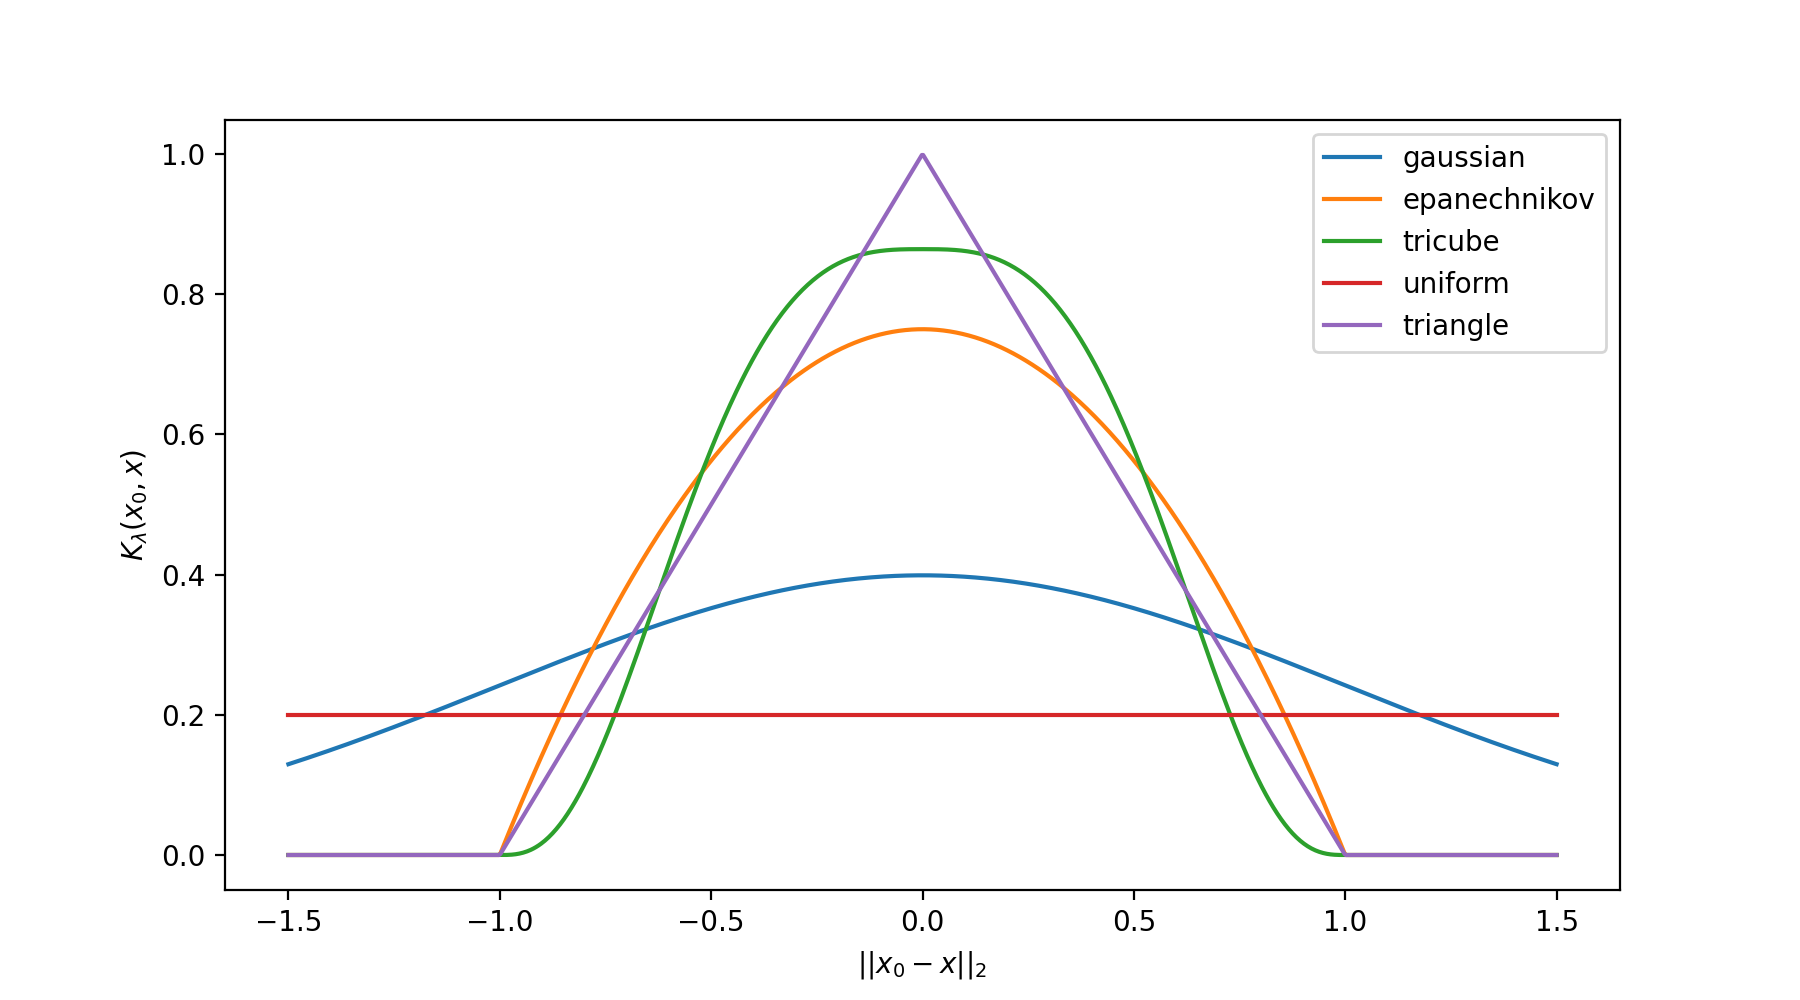

In [21]:
def gaussian(t):
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi)

def epanechnikov(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = 0.75 * (1 - t[np.abs(t) <= 1]**2)
    return res

def tricube(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = (70 / 81) * (1 - np.abs(t[np.abs(t) <= 1])**3)**3
    return res

def uniform(t, p=0.2):
    return np.zeros_like(t) + p

def triangle(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = 1 - np.abs(t[np.abs(t) <= 1])
    return res

fig, ax = plt.subplots(figsize=(9, 5))

xs = np.linspace(-1.5, 1.5, 1000)
for func in [gaussian, epanechnikov, tricube, uniform, triangle]:
    ax.plot(xs, func(xs), label=func.__name__)

ax.legend()
ax.set_ylabel("$K_{\lambda}(x_0, x)$")
ax.set_xlabel("$||x_0 - x||_2$")
#fig.tight_layout()
fig.canvas.draw()

## 2 - Locally Weighted Least-Sqaures

### Objective Function
We solve a separate weighted least squares problem at each target point $x_0$ such that

$$J(\theta({x_0})) = \sum_{i=1}^N k(x_0, x_i) [y_i - x_i^\top \theta({x_0})]^2.$$

Taking the gradient with respect to $\theta_{x_0}$,

$$\frac{d J}{d \theta_j({x_0})} = -2 \sum_{i=1}^N k(x_0, x_i) [y_i - x_i^\top \theta({x_0})] x_{i, j}$$

Set this to equal 0 and expand,

$$
\begin{align}
\sum_{i=1}^N k(x_0, x_i) [y_i - x_i^\top \theta({x_0})] x_{i, j} &= 0 \\
\left(\sum_{i=1}^N k(x_0, x_i) x_{ij} x_i^\top \theta({x_0})\right)  &= \sum_{i=1}^N k(x_0, x_i) y_i x_{ij}
\end{align}
$$

So for all $M$ input dimensions we get that,

$$
\begin{align}
\begin{bmatrix}
\sum_{i=1}^N k(x_0, x_i) x_{i, 1} x_i^\top \theta({x_0})\\
\vdots \\
\sum_{i=1}^N k(x_0, x_i) x_{i, M} x_i^\top \theta({x_0})
\end{bmatrix}
&= \begin{bmatrix}
\sum_{i=1}^N K(x_0, x_i) y_i x_{i,1} \\
\vdots \\
\sum_{i=1}^N K(x_0, x_i) y_i x_{i,M}
\end{bmatrix}
\end{align}
$$

### General Solution
If we let $K$ be a diagonal matrix with the $i$-th diagonal element equal to $k(x_0, x_i)$, we can write the following,

$$
\begin{align}
\begin{bmatrix}
\sum_{i=1}^N k(x_0, x_i) x_{i,1} \\
\vdots \\
\sum_{i=1}^N k(x_0, x_i) x_{i,M}
\end{bmatrix} = \textbf{X}^T \, \textbf{K}
\end{align}
$$

We can therefore split out the left-hand side side as follows,

$$
\begin{align}
\begin{bmatrix}
\sum_{i=1}^N k(x_0, x_i) x_{i, 1} x_i^\top\\
\vdots \\
\sum_{i=1}^N k(x_0, x_i) x_{i, M} x_i^\top
\end{bmatrix}
&= \textbf{X}^T \, \textbf{K} \, \textbf{X}
\end{align}
$$

Finally we write the full expression more generally as,
$$\textbf{X}^T \, \textbf{K} \, \textbf{X} \,  \Theta = \textbf{X}^T \, \textbf{K} \, \textbf{y}$$

### OLS Similarity

We solve the above,
$$\Theta = (\textbf{X}^T \, \textbf{K} \, \textbf{X})^{-1} \textbf{X}^T \, \textbf{K} \, \textbf{y}$$

Notice the similarity to OLS,
$$\Theta^{\textrm{ols}} = (\textbf{X}^T \, \textbf{X})^{-1} \textbf{X}^T  \, \textbf{y}$$

We just have some additional weights (but recall also we have one model per training point).

## 3 - Experiment

Suppose our true function is given by,

$$y = (1 - x_2)\sin(0.5 \pi x_1)$$

with,

$$x_1, x_2 \sim \textrm{Uniform}(0, 1)$$

<IPython.core.display.Javascript object>


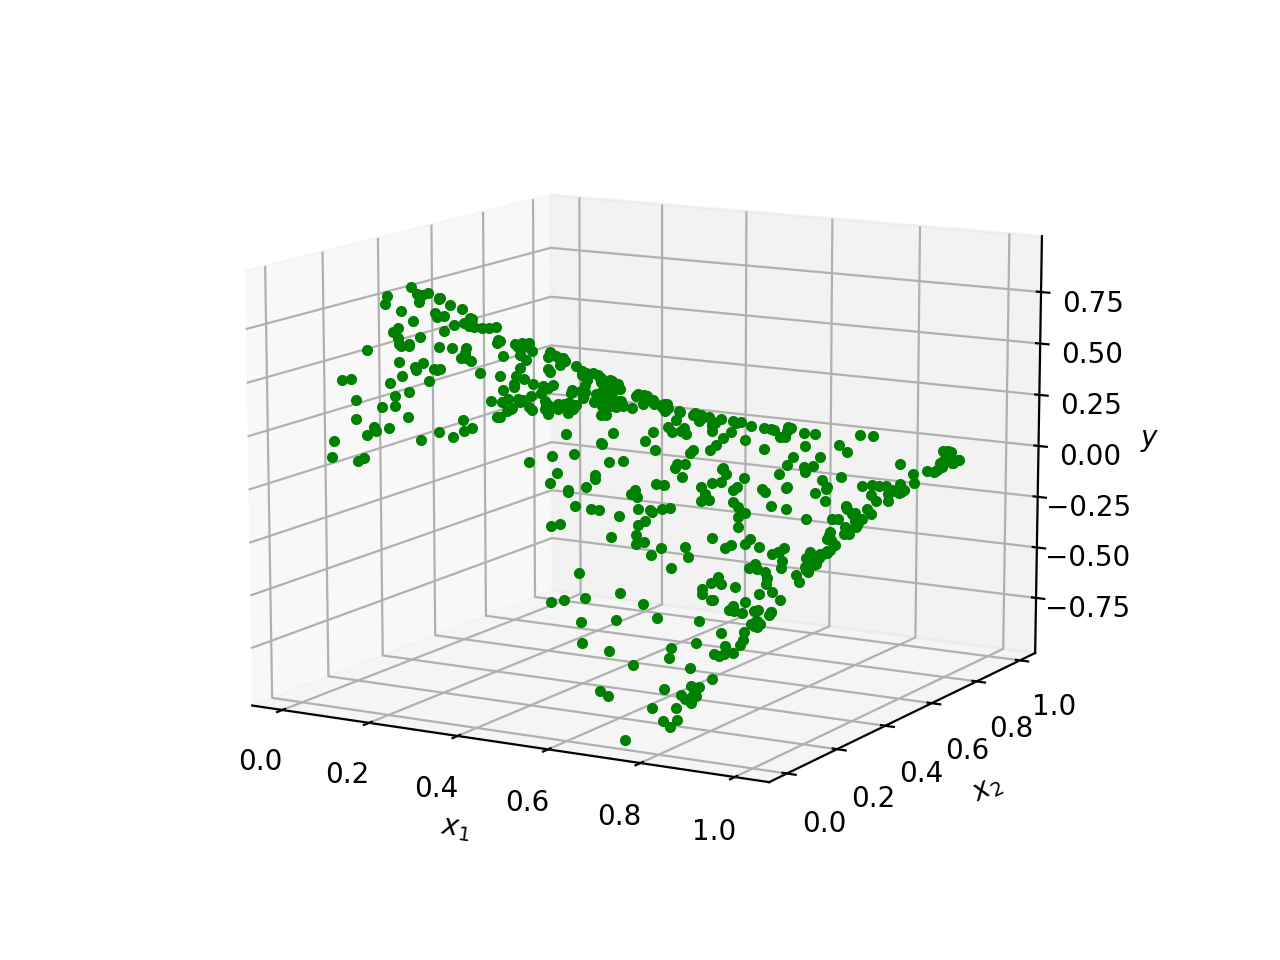

In [22]:
sample_size = 500
X = np.random.rand(sample_size, 2)
y = np.sin(2 * np.pi * X[:,0]) * (1 - X[:, 1])

fig = plt.figure()

ax = fig.add_subplot(111,  projection='3d')
ax.plot3D(X[:,0], X[:,1], y, '.', color="green")

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$y$")

fig.tight_layout()
fig.canvas.draw()

## Ordinary Least Squares

In [23]:
limits = np.arange(0, 1.05, 0.05)
X1_grid, X2_grid = np.meshgrid(limits, limits)
X_query = np.array([np.ravel(X1_grid), np.ravel(X2_grid)]).T # Generate some test data.

In [24]:
theta = np.linalg.inv(X.T @ X) @ X.T @ y.reshape(-1, 1)
y_pred_ols = X_query @ theta

<IPython.core.display.Javascript object>


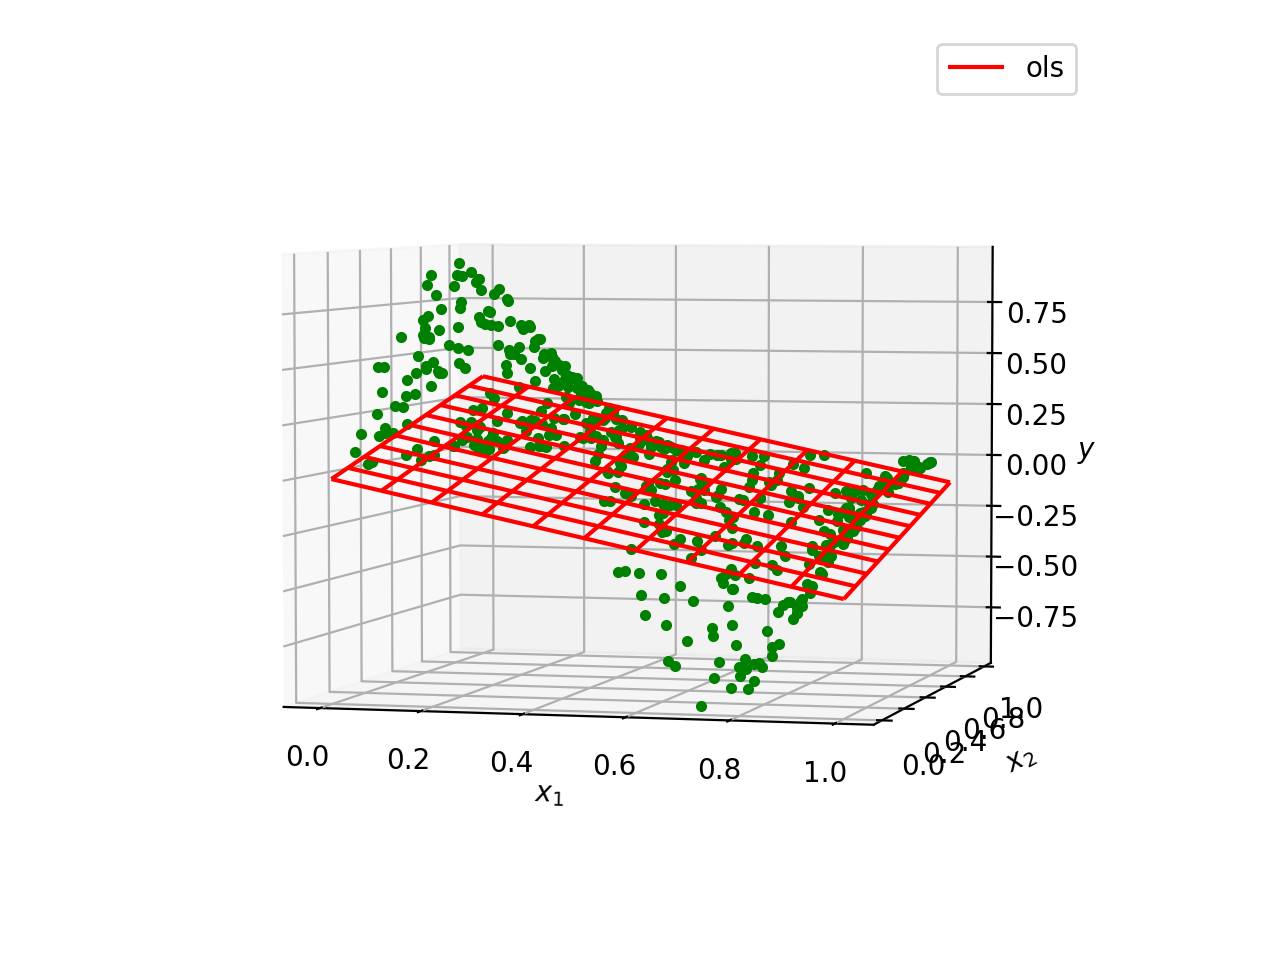

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111,  projection='3d')
ax.plot3D(X[:,0], X[:,1], y, '.', color="green")

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$y$")

ax.plot_wireframe(
    X1_grid, X2_grid, y_pred_ols.reshape(X1_grid.shape), rcount=15, ccount=15, color="red", label="ols")
ax.legend()

fig.tight_layout()
plt.show()

## Locally Weighted Least Squares

In [28]:
%time 
radius = 0.2

y_pred_wls = np.zeros(len(X_query))
for i in range(len(X_query)):
    W = np.diagflat(epanechnikov(np.linalg.norm(X - X_query[i], axis=1) / radius))
    theta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y.reshape(-1, 1)
    y_pred_wls[i] = X_query[i] @ theta

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 22.6 µs


<IPython.core.display.Javascript object>


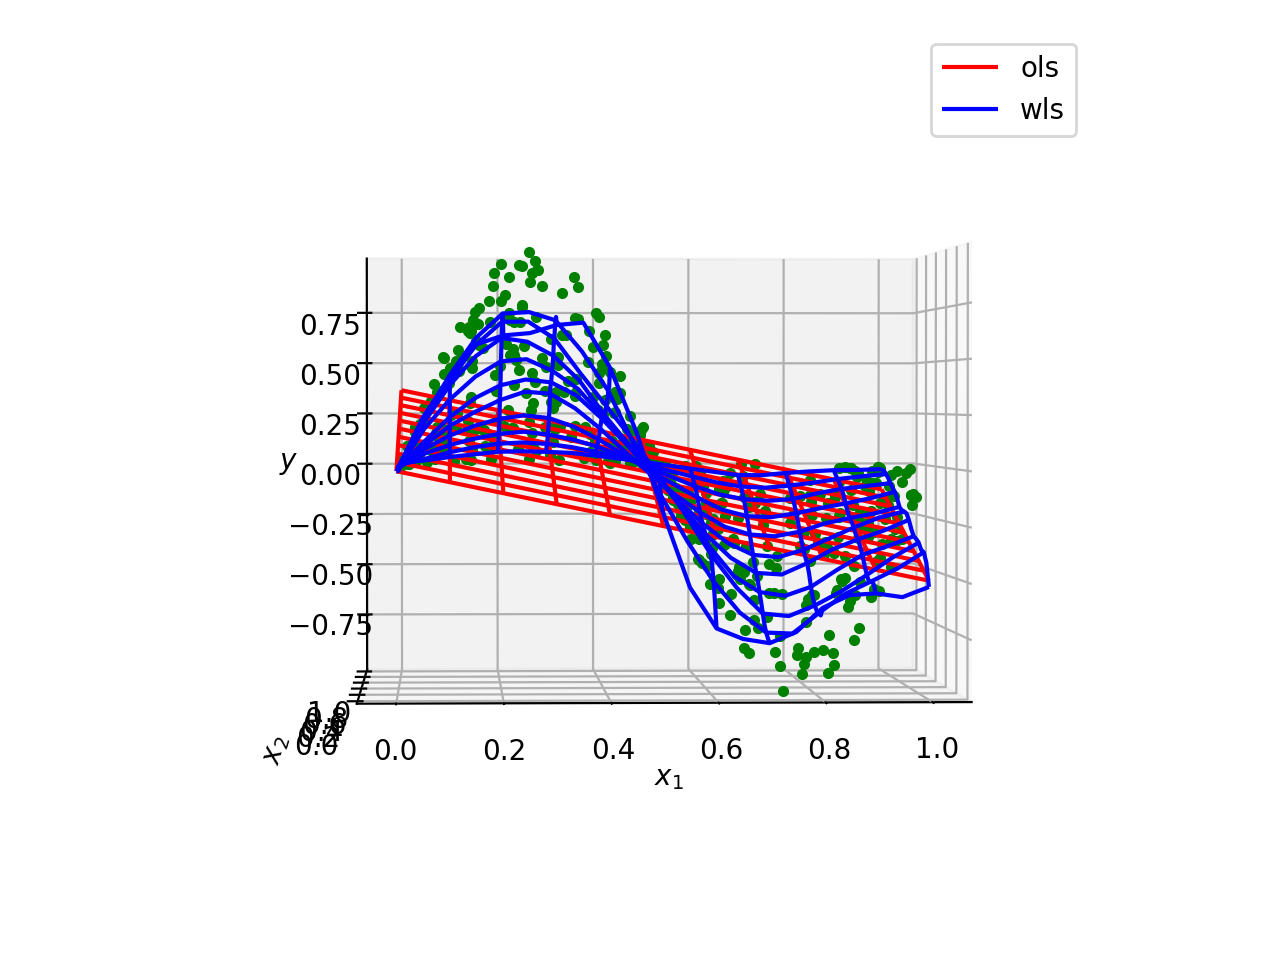

In [27]:
fig = plt.figure()

ax = fig.add_subplot(111,  projection='3d')
ax.plot3D(X[:,0], X[:,1], y, '.', color="green")

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$y$")

ax.plot_wireframe(
    X1_grid, X2_grid, y_pred_ols.reshape(X1_grid.shape), rcount=15, ccount=15, color="red", label="ols")

ax.plot_wireframe(
    X1_grid, X2_grid, y_pred_wls.reshape(X1_grid.shape), rcount=15, ccount=15, color="blue", label="wls")

ax.legend()

fig.tight_layout()
plt.show()

## 4 - Open Questions
* What is the computational cost of this method?
* How sensitive are the results to different kernels?
* Can we generalize to locally weighted polynomial regression?
* Why might this method fall short in high dimensions? What other techniques can we use?

**Recommended reading**:
```
@book{hastie2009elements,
  title={The elements of statistical learning: data mining, inference, and prediction},
  author={Hastie, Trevor and Tibshirani, Robert and Friedman, Jerome H and Friedman, Jerome H},
  volume={2},
  year={2009},
  publisher={Springer}
}
```